# Capstone Project for Investment and Trading

<font color='gray' size=4> (1) Sourcing market Data from Quandl </font> 

This script is for downloading financial data required for predicting S&P500 daily return. Source is from Quandl API and <font color='red'>do not need to run this</font> since everything is already downloaded as parsed as CSV files in local directories.

In [24]:
import quandl
import utility as util
import process as proc

quandl.ApiConfig.api_key = "dmDantC6pfu5ZsSZ9Zny"

date_range = ["2010-01-01", "2016-12-31"]
#spy: S&P500 index
spy = quandl.get("YAHOO/INDEX_GSPC", start_date=date_range[0], end_date=date_range[1])
#nasdaq: NASDAQ composite index
nas = quandl.get("YAHOO/INDEX_IXIC", start_date=date_range[0], end_date=date_range[1])
#dax: German stock market index
dax = quandl.get("YAHOO/INDEX_GDAXI", start_date=date_range[0], end_date=date_range[1])
#nikkei 225: Japan stock market index
nik = quandl.get("YAHOO/INDEX_N225", start_date=date_range[0], end_date=date_range[1])
#kpi: KOSPI index from Korea
#kpi = quandl.get("YAHOO/INDEX_KS11", start_date=date_range[0], end_date=date_range[1])
#glf: Chicago Merchandile Exchange NYMEX Gold Futures
glf = quandl.get("CHRIS/CME_GC1", start_date=date_range[0], end_date=date_range[1])
#oif: Crude Oil Futures based on spot-month continuous contract 
olf = quandl.get("CHRIS/CME_CL1", start_date=date_range[0], end_date=date_range[1])

spy = spy.rename(columns = {'Volume':'SPY:Volume', 'Adjusted Close':'SPY:Price'})
nas = nas.rename(columns = {'Volume':'NAS:Volume', 'Adjusted Close':'NAS:Price'})
dax = dax.rename(columns = {'Volume':'DAX:Volume', 'Adjusted Close':'DAX:Price'})
nik = nik.rename(columns = {'Volume':'NIK:Volume', 'Adjusted Close':'NIK:Price'})
#kpi = kpi.rename(columns = {'Volume':'KPI:Volume', 'Adjusted Close':'KPI:Price'})
glf = glf.rename(columns = {'Volume':'GLF:Volume', 'Settle':'GLF:Price'})
olf = olf.rename(columns = {'Volume':'OLF:Volume', 'Settle':'OLF:Price'})

#Set date index from spy as a reference
date_index = spy.index.get_values()

#Get processed dataframe
df = proc.get_mkt_data(date_index, spy, nas, dax, nik, glf, olf)
print df.head()

#Save data to csv file
util.save_data('mkt_price_volume.csv',df)

              SPY:Volume    SPY:Price    NAS:Volume    NAS:Price  DAX:Volume  \
2010-01-04  3.991400e+09  1132.989990  1.931380e+09  2308.419922  24260800.0   
2010-01-05  2.491020e+09  1136.520020  2.367860e+09  2308.709961  27329600.0   
2010-01-06  4.972660e+09  1137.140015  2.253340e+09  2301.090088  24605300.0   
2010-01-07  5.270680e+09  1141.689941  2.270050e+09  2300.050049  30059600.0   
2010-01-08  4.389590e+09  1144.979980  2.145390e+09  2317.169922  31735200.0   

              DAX:Price  NIK:Volume     NIK:Price  GLF:Price  GLF:Volume  \
2010-01-04  6048.299805    104400.0  10654.790039     1118.3     64594.0   
2010-01-05  6031.859863    166200.0  10681.830078        NaN         NaN   
2010-01-06  6034.330078    181800.0  10731.450195     1136.5    156414.0   
2010-01-07  6019.359863    182600.0  10681.660156     1133.7    176903.0   
2010-01-08  6037.609863    211800.0  10798.320312     1138.9    121150.0   

            OLF:Price  OLF:Volume  
2010-01-04      81.51    2

<font color='gray' size=4> (2) Preprocessing input features </font> 

First step with dealing financial data is to fill missing values for every columns. Instead of using interpolation, we will just fill with latest value. This is to avoid information leaking into future to prevent optimistic result. Finally, we are ready to process input data to our learning models. However, if you see the distribution of stock price, it seems to follow somewhat binomial distribution. Hence, instead of just using price data we will turn it to a daily return. We can see that daily return, not exactly though because of fat tail, shows normal distribution. Refer to some statistics below for our daily return distribution.

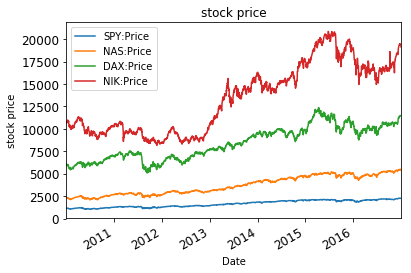

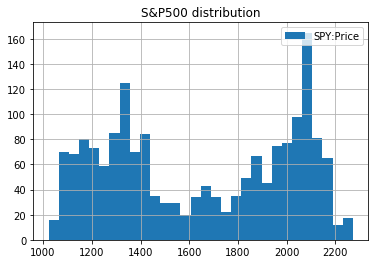

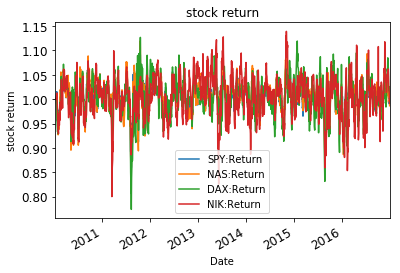

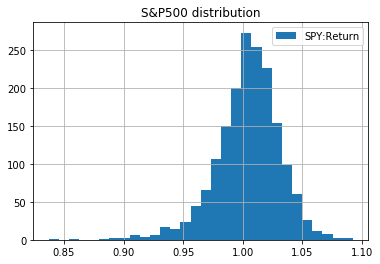

Statistics for SPY:Return
     statistic           value
------------------------------
          size      1762.00000
           min         0.83702
           max         1.09246
          mean         1.00425
           std         0.02691
          skew        -0.78328
      kurtosis         2.49443


In [7]:
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Read data from CSV files
mkt_df = proc.read_mkt_data('mkt_price_volume.csv')
# Display a description of the dataset
#display(mkt_df.describe())

# Fill missing value
data_before = proc.fill_missing_values(mkt_df)

# Divide data into categories(stock index, commodity, interest rates)
stock_price = data_before[['SPY:Price', 'NAS:Price', 'DAX:Price', 'NIK:Price']]
commodity_price = data_before[['GLF:Price', 'OLF:Price']]

# Before Preprocessing data
util.plot_data(stock_price, 'stock price')
util.plot_histogram(stock_price[['SPY:Price']], 'S&P500 distribution')

# Preprocess: Price to Daily Returns, this also changes volume to daily increase
data_after = proc.price_to_return(data_before, 'Price', 'Return', day_10)

# Divide data into categories(stock index, commodity, interest rates)
stock_return = data_after[['SPY:Return', 'NAS:Return', 'DAX:Return', 'NIK:Return']]
commodity_return = data_after[['GLF:Return', 'OLF:Return']]

# After Preprocessing data
util.plot_data(stock_return, 'stock return')
util.plot_histogram(stock_return[['SPY:Return']], 'S&P500 distribution')

print "Statistics for SPY:Return"
proc.print_statistics(stock_return['SPY:Return'])

We can apply same converting logic to volume data. Volume means trade volume, quantity of an order made in each day. As you can see from below figure however, raw volume data is more like normal distribution than converted data. Hence, for volume we will just stick with original series.

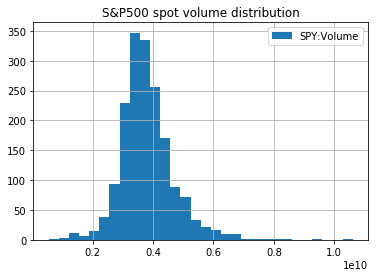

Statistics for SPY:Volume
     statistic           value
------------------------------
          size      1762.00000
           min 536200000.00000
           max 10617809600.00000
          mean 3796473024.74461
           std 879457321.79412
          skew         1.06084
      kurtosis         4.83376


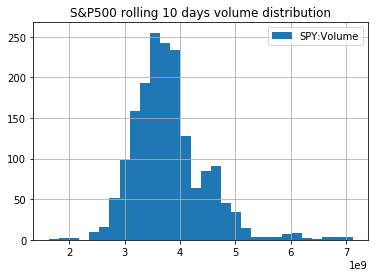

Statistics for SPY:Volume(10D)
     statistic           value
------------------------------
          size      1762.00000
           min 1626553000.00000
           max 7121765000.00000
          mean 3801428562.76958
           std 655254810.13675
          skew         1.15130
      kurtosis         3.04685


In [16]:
# Divide data into categories(stock index, commodity, interest rates)
volume = data_before[['SPY:Volume']]

# Preprocess
rolling_volume = proc.get_rolling_mean(spy_volume, day_10)
rolling_volume = proc.fill_missing_values(spy_rolling_volume)

# Before Preprocessing data
util.plot_histogram(volume, 'S&P500 spot volume distribution')
print "Statistics for SPY:Volume"
proc.print_statistics(volume['SPY:Volume'])

# After Preprocessing data
util.plot_histogram(rolling_volume, 'S&P500 rolling 10 days volume distribution')
print "Statistics for SPY:Volume(10D)"
proc.print_statistics(rolling_volume['SPY:Volume'])

<font color='gray' size=4> (3) Selecting features </font> 

Our goal is to predict S&P500 return, whether it's price is expected to go up or down. Our portfolio strategy heavily depends on this prediction. In order to predict S&P500 movement, we have selected various features from above. In this section, we will find relevant features for predicting S&P500 return.

                 SPY:Return(10D)  NAS:Return(10D)  DAX:Return(10D)  \
SPY:Return(10D)         1.000000         0.951875         0.764184   
NAS:Return(10D)         0.951875         1.000000         0.748444   
DAX:Return(10D)         0.764184         0.748444         1.000000   
NIK:Return(10D)         0.624404         0.613740         0.616134   
GLF:Return(10D)        -0.003888        -0.009722        -0.079454   
OLF:Return(10D)         0.432435         0.400298         0.322211   
SPY:Target              0.429326         0.393964         0.320363   

                 NIK:Return(10D)  GLF:Return(10D)  OLF:Return(10D)  SPY:Target  
SPY:Return(10D)         0.624404        -0.003888         0.432435    0.429326  
NAS:Return(10D)         0.613740        -0.009722         0.400298    0.393964  
DAX:Return(10D)         0.616134        -0.079454         0.322211    0.320363  
NIK:Return(10D)         1.000000        -0.221167         0.255030    0.226382  
GLF:Return(10D)        -0.221167  

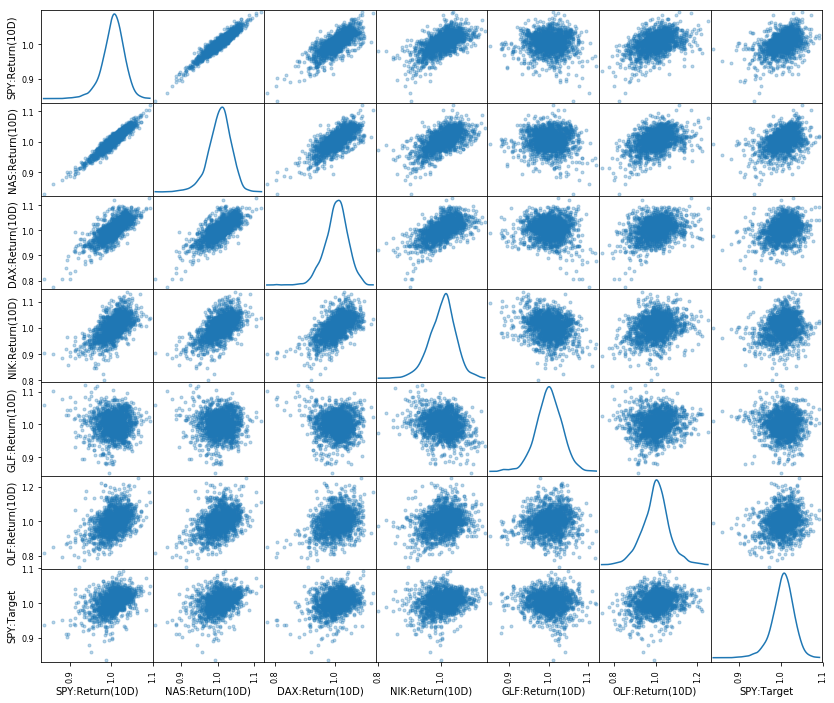

In [25]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#ScatterPlot
df = day_10_return
df = df.join(target)
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');
print df.corr(method='pearson')

From above scatterplot, we can see that GLF(Gold Future) has low correlation with our SPY:Target value. In which, we can hardly explain our target with gold future variable. Also, we will drop NAS(nasdaq) since this feature move almost same with SPY(S&P500). One should be enought for predicting future S&P500 value. After removing let's add some S&P 1day, 5day, 20day cumulative return to our feature sets.

                 SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
SPY:Return(10D)         1.000000         0.764184         0.624404   
DAX:Return(10D)         0.764184         1.000000         0.616134   
NIK:Return(10D)         0.624404         0.616134         1.000000   
OLF:Return(10D)         0.432435         0.322211         0.255030   
SPY:Target              0.429326         0.320363         0.226382   
SPY:Return(1D)          0.279484         0.167645         0.024329   
SPY:Return(5D)          0.644749         0.490386         0.353469   
SPY:Return(20D)         0.663314         0.538692         0.479655   

                 OLF:Return(10D)  SPY:Target  SPY:Return(1D)  SPY:Return(5D)  \
SPY:Return(10D)         0.432435    0.429326        0.279484        0.644749   
DAX:Return(10D)         0.322211    0.320363        0.167645        0.490386   
NIK:Return(10D)         0.255030    0.226382        0.024329        0.353469   
OLF:Return(10D)         1.000000    0.222915     

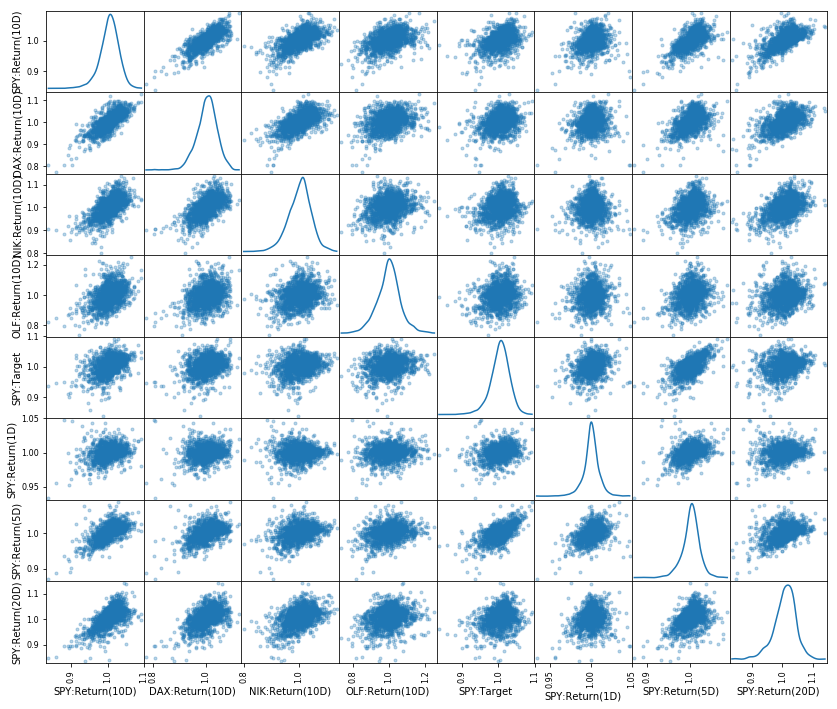

In [26]:
df.drop('GLF:Return(10D)', axis = 1, inplace = True)
df.drop('NAS:Return(10D)', axis = 1, inplace = True)
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

print df.corr(method='pearson')
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');

Now, lets dive into volume data. For volume we will treat only volume data for S&P500. As shown above, we will preprocess our raw volume data into rolling mean datas.

                 SPY:Volume(1D)  SPY:Volume(5D)  SPY:Volume(10D)  \
SPY:Volume(1D)         1.000000        0.780958         0.693605   
SPY:Volume(5D)         0.780958        1.000000         0.916926   
SPY:Volume(10D)        0.693605        0.916926         1.000000   
SPY:Volume(20D)        0.621578        0.808972         0.914313   
SPY:Target            -0.121729       -0.084534        -0.040558   

                 SPY:Volume(20D)  SPY:Target  
SPY:Volume(1D)          0.621578   -0.121729  
SPY:Volume(5D)          0.808972   -0.084534  
SPY:Volume(10D)         0.914313   -0.040558  
SPY:Volume(20D)         1.000000   -0.045456  
SPY:Target             -0.045456    1.000000  


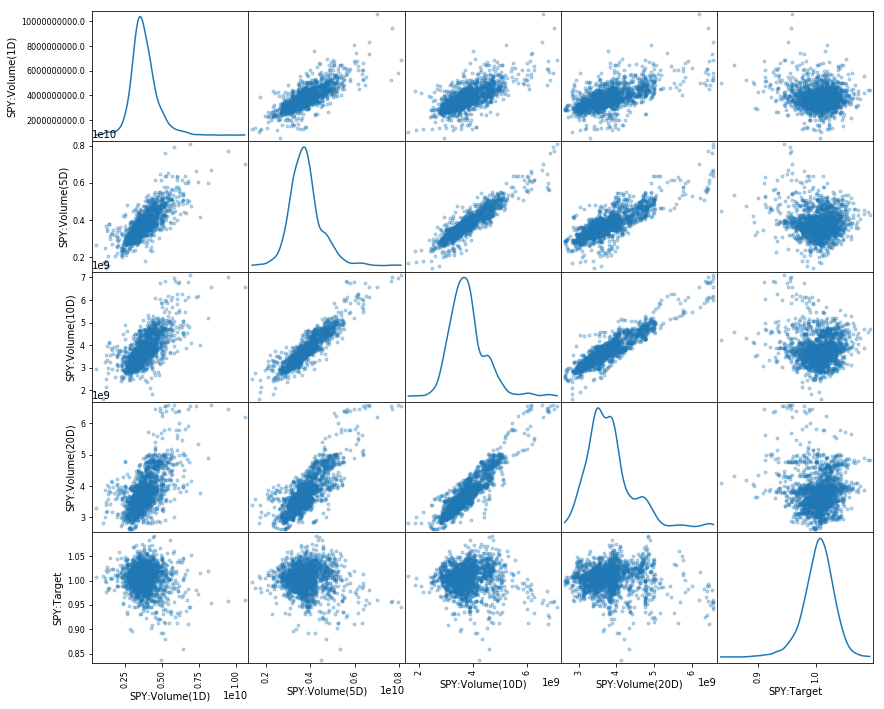

In [34]:
volume_data = proc.extract_columns(raw_data, 'Volume')
spy_volume = volume_data['SPY:Volume']
day_1_volume = proc.get_rolling_mean(spy_volume, day_1)
day_1_volume.name = spy_volume.name.replace('Volume', 'Volume(1D)')
day_5_volume = proc.get_rolling_mean(spy_volume, day_5)
day_5_volume.name = spy_volume.name.replace('Volume', 'Volume(5D)')
day_10_volume = proc.get_rolling_mean(spy_volume, day_10)
day_10_volume.name = spy_volume.name.replace('Volume', 'Volume(10D)')
day_20_volume = proc.get_rolling_mean(spy_volume, day_20)
day_20_volume.name = spy_volume.name.replace('Volume', 'Volume(20D)')

df = pd.DataFrame(index=target.index.get_values())
df = df.join(day_1_volume)
df = df.join(day_5_volume)
df = df.join(day_10_volume)
df = df.join(day_20_volume)
df = df.join(target)
df = proc.fill_missing_values(df)

print df.corr(method='pearson')
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');

Unfortunately, we could not find any relavance between volume of S&P500 and future cumulative return of S&P500. To summarize, with regards to feature inputs, we will use 10 day cumulative return from SPY, DAX, NIK, OLF and daily return, 5-day cumulative return, and 20-day cumulative return for S&P500. All this inputs are for predicting future S&P500 index. 

<font color='gray' size=4> (4) Model Learning & Validation </font> 

Now we are ready to learn our model. First, we will preprocess raw data, drop and select some features. Details can be found (3) Selecting Features.

In [3]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
price_data.drop('GLF:Price', axis = 1, inplace = True)
price_data.drop('NAS:Price', axis = 1, inplace = True)

day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#features
df = day_10_return
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

print df.head()

            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2010-01-04              1.0              1.0              1.0   
2010-01-05              1.0              1.0              1.0   
2010-01-06              1.0              1.0              1.0   
2010-01-07              1.0              1.0              1.0   
2010-01-08              1.0              1.0              1.0   

            OLF:Return(10D)  SPY:Return(1D)  SPY:Return(5D)  SPY:Return(20D)  
2010-01-04              1.0        1.000000             1.0              1.0  
2010-01-05              1.0        1.003116             1.0              1.0  
2010-01-06              1.0        1.000546             1.0              1.0  
2010-01-07              1.0        1.004001             1.0              1.0  
2010-01-08              1.0        1.002882             1.0              1.0  


We will divide our data into training sets and testing set. We will use 2010-2015 data for training and 2015-2016 data for simulating our portfolio strategy. But before that, we have to take care of some NaN values and fake values that come from rolling mean and cumultavie mean. Simply, we will exclude meaningless data. Front 20, and last 20 data will be removed. 

In [4]:
train_range = ["2010-01-01", "2015-12-31"]
test_range = ["2016-01-01", "2016-12-31"]

df_after = df[day_20:-day_20]
target_after = target[day_20:-day_20]

X_train = df_after.ix[train_range[0]:train_range[1]]
y_train = target_after.ix[train_range[0]:train_range[1]]
X_test = df_after.ix[test_range[0]:test_range[1]]
y_test= target_after.ix[test_range[0]:test_range[1]]

print X_train.head()
print X_test.tail()

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2010-02-02         0.959217         0.955355         0.963417   
2010-02-03         0.964184         0.969335         0.968970   
2010-02-04         0.952198         0.962810         0.952851   
2010-02-05         0.976579         0.954176         0.949629   
2010-02-08         0.963493         0.973981         0.946648   

            OLF:Return(10D)  SPY:Return(1D)  SPY:Return(5D)  SPY:Return(20D)  
2010-02-02         0.977348        1.012973        1.010209         0.973813  
2010-02-03         0.991755        0.994526        0.999800         0.965474  
2010-02-04         0.961356        0.968859        0.980249         0.934898  
2010-02-05         0.955058        1.002897        0.992848         0.933870  
2010-02-08         0.955222        0.991137        0.970207         0.922933  
            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2016-11-25         1.021163         1.006505         1.059777   
2016-

Typical usage of cross validation does not fit financial data application well. The reason is that it can permit peeking into the future. For instance, if our training data is after testing data that means we are seeing the future ahead of our test. Any sort of peeking like this can read to unrealistically optimistic results. This is why we divided train(2010-2015), test(2015-2016) sets in chronogical order rather than using train_test_split function from sklearn.cross_validation. One way to avoid this problem is with role forward cross validation. That mean our training data is always before testing data. And we can still have multiple trials just by rolling our data forward till we run out of data.

In [8]:
import run
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

reg_knn = KNeighborsRegressor()
reg_dt = DecisionTreeRegressor()
reg_svr = SVR()
reg_rf = RandomForestRegressor()

params_knn = {'n_neighbors': range(5,31), 'weights': ['uniform']} #'distance'
params_dt = {'max_depth': range(1,10)}
params_svm = {'kernel': ['rbf'], 
              'C': [1.0, 3.0, 10.0],
              'epsilon': [0.01, 0.03, 0.1]}
params_rf = {'n_estimators': [30,40,50],
             'max_depth': range(1,10)}

# Fit the training data to the model using grid search
#reg = run.fit_regression(reg_dt, X_train, y_train, params_dt)
#reg = run.fit_regression(reg_knn, X_train, y_train, params_knn)
#reg = run.fit_regression(reg_ada, X_train, y_train, params_ada)
reg = run.fit_regression(reg_rf, X_train, y_train, params_rf)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print "Parameter 'n_estimators' is {} for the optimal model.".format(reg.get_params()['n_estimators'])

print run.get_r2_score(reg, X_test, y_test)

Parameter 'max_depth' is 3 for the optimal model.
Parameter 'n_estimators' is 50 for the optimal model.
0.511279015844


<font color='gray' size=4> (5) Portfolio Construction Strategy </font> 

Our goal is to construct a portfolio that can beat S&P500 index. We will use stocks from S&P500 list for constructing portfolio. Below is code for downloading financial data for stocks that are constitunt of S&P500. Do not run this code because it will take too much time.

In [3]:
import quandl
import process as proc
import utility as util

quandl.ApiConfig.api_key = "dmDantC6pfu5ZsSZ9Zny"

mkt_df = proc.read_mkt_data('mkt_price_volume.csv')
date_range = ["2010-01-01", "2016-12-31"]
date_index = mkt_df.index.get_values()
 
stock_df = proc.get_total_stocks('S&P500_list.csv', date_index, date_range)
util.save_data('S&P500_stocks_price.csv', stock_df)

0. 3M Company Download & Parse complete
1. Abbott Laboratories Download & Parse complete
2. AbbVie Download & Parse complete
3. Accenture plc Download & Parse complete
4. ACE Limited Download & Parse complete
5. Activision Blizzard Download & Parse complete
6. Adobe Systems Inc Download & Parse complete
7. ADT Corp Download & Parse complete
8. Advance Auto Parts Download & Parse complete
9. AES Corp Download & Parse complete
10. Aetna Inc Download & Parse complete
11. AFLAC Inc Download & Parse complete
12. Affiliated Managers Group Inc Download & Parse complete
13. Agilent Technologies Inc Download & Parse complete
14. AGL Resources Inc. Download & Parse complete
15. Air Products & Chemicals Inc Download & Parse complete
16. Airgas Inc Download & Parse complete
17. Akamai Technologies Inc Download & Parse complete
18. Alcoa Inc Download & Parse complete
19. Allergan plc Download & Parse complete
20. Alexion Pharmaceuticals Download & Parse complete
21. Allegion Download & Parse comple

To avoid survivors bias which might accidentally happen if we tend to use survived companies from 2016 S&P500 constituent, we will only use stocks that has existed from 2010.

In [1]:
import process as proc
import numpy as np

spy = proc.read_mkt_data('mkt_price_volume.csv')
spy = spy['SPY:Price']
spy.name = 'SPY'
# Preprocess data
stocks = proc.read_stock_data('S&P500_stocks_price.csv')
stocks = proc.fill_missing_values(stocks)
stocks = stocks.join(spy)

List of companies dropped due to insufficient data
ABBV
ACE
ADT
GAS
ARG
AA
ALLE
GOOG
ALTR
BXLT
BRCM
CVC
CAM
CCE
CPGX
CMCSK
CSC
CNX
DLPH
EMC
ESV
FB
FOSL
GM
GNW
HCA
HCBK
GMCR
KMI
KHC
LM
LYB
MNK
MPC
MHFI
WRK
KORS
NAVI
NWSA
NWS
NLSN
OI
PYPL
POM
PSX
PCL
PCP
QRVO
SNDK
SIAL
HOT
TE
TGNA
THC
TWC
TRIP
TYC
WBA
ANTM
XYL
ZBH
ZTS


Our strategy is to select stocks depending on market forecast. Based on CAPM, if market is expected to rise, we will select stocks with high beta, and vice versa. 

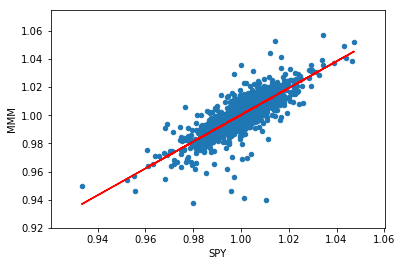

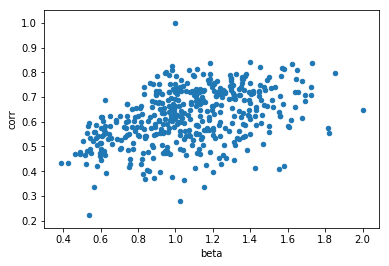

          beta     alpha      corr
MMM   0.949403  0.050787  0.799594
ABT   0.740617  0.259453  0.622333
ACN   0.999657  0.000621  0.693163
ATVI  0.854832  0.145656  0.476372
ADBE  1.132466 -0.132220  0.623042


In [2]:
import run
import matplotlib.pyplot as plt
import utility as util
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

util.plot_stock_CAPM(stocks, 'MMM')
capm = run.get_stocks_CAPM(stocks)
capm.plot(kind='scatter', x='beta', y='corr')
plt.show()

print capm.head()

<font color='gray' size=4> (6) Simulation </font> 

In [16]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import run
from sklearn.ensemble import RandomForestRegressor

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
price_data.drop('GLF:Price', axis = 1, inplace = True)
price_data.drop('NAS:Price', axis = 1, inplace = True)

day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#features
df = day_10_return
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

train_range = ["2010-01-01", "2015-12-31"]

df_after = df[day_20:-5]
target_after = target[day_20:-5]

X_train = df_after.ix[train_range[0]:train_range[1]]
y_train = target_after.ix[train_range[0]:train_range[1]]

print X_train.tail()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

reg = RandomForestRegressor(n_estimators=30, max_depth=3)
reg = reg.fit(X_train, y_train)

            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2015-12-24         1.004269         1.012144         0.986514   
2015-12-28         1.021929         1.030353         0.981429   
2015-12-29         1.027904         1.071089         1.005233   
2015-12-30         1.009763         1.028002         1.025197   
2015-12-31         0.985948         1.026148         0.999150   

            OLF:Return(10D)  SPY:Return(1D)  SPY:Return(5D)  SPY:Return(20D)  
2015-12-24         1.036453        0.998401        1.009354         0.986653  
2015-12-28         1.033408        0.997821        1.025404         0.983919  
2015-12-29         1.042963        1.010630        1.028306         0.999015  
2015-12-30         0.979920        0.992783        1.011962         0.981323  
2015-12-31         1.042793        0.990588        0.990142         0.982895  


In [19]:
test_range = ["2016-01-01", "2016-12-31"]

X_test = df_after.ix[test_range[0]:test_range[1]]
print X_test.loc(0)

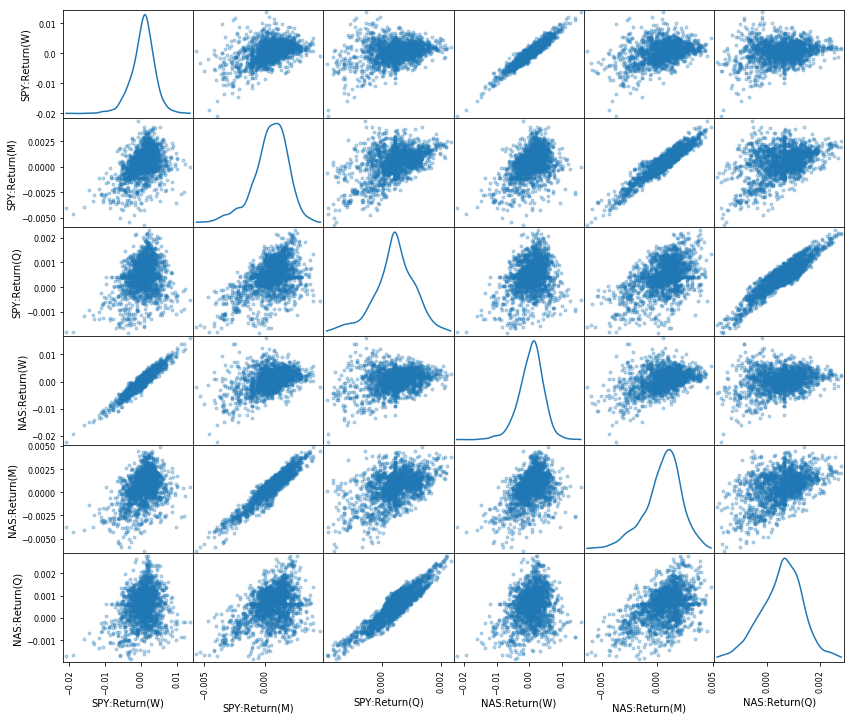

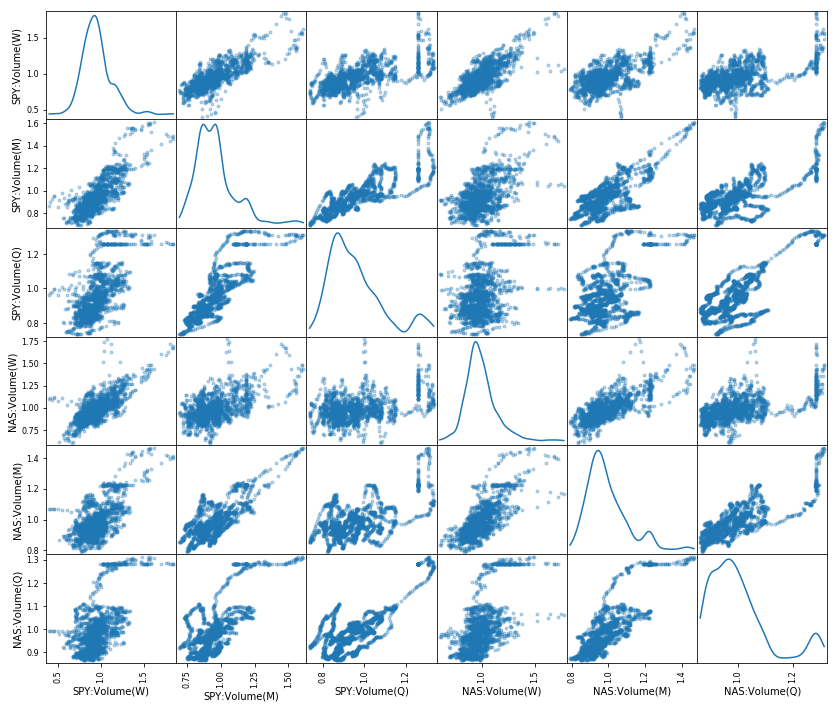

In [3]:
import pandas as pd

return_feature = ['SPY:Return(W)', 'SPY:Return(M)', 'SPY:Return(Q)', 'NAS:Return(W)', 
                   'NAS:Return(M)', 'NAS:Return(Q)']
volume_feature = ['SPY:Volume(W)', 'SPY:Volume(M)', 'SPY:Volume(Q)', 'NAS:Volume(W)', 
                   'NAS:Volume(M)', 'NAS:Volume(Q)']
return_data = data[return_feature]
volume_data = data[volume_feature]

pd.scatter_matrix(return_data, alpha = 0.3, figsize = (14,12), diagonal = 'kde');
pd.scatter_matrix(volume_data, alpha = 0.3, figsize = (14,12), diagonal = 'kde');

To be updated

Dimension 1    0.7534
Dimension 2    0.8749
Dimension 3    0.9492
Dimension 4    0.9813
Dimension 5    0.9962
Dimension 6    0.9998
Name: Explained Variance, dtype: float64


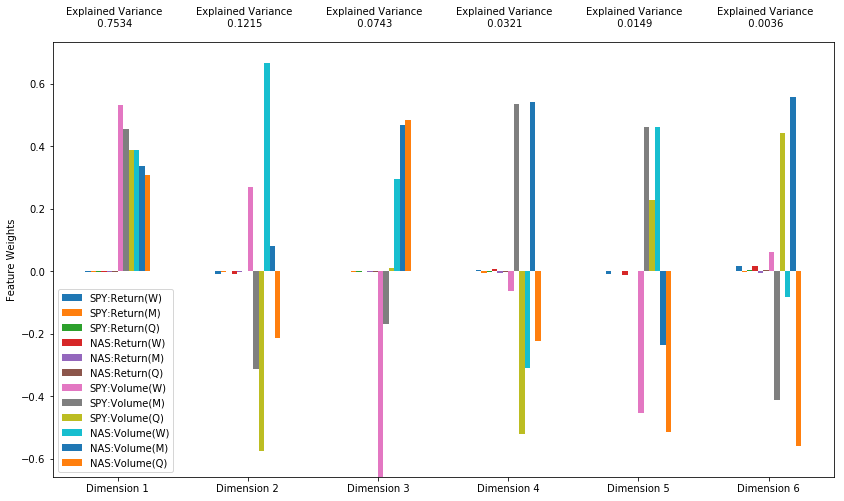

In [4]:
# boxcox: http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html
from sklearn.decomposition import PCA
import renders as rs

# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(data)

# Generate PCA results plot
pca_results = rs.pca_results(data, pca)
print pca_results['Explained Variance'].cumsum()

To be updated

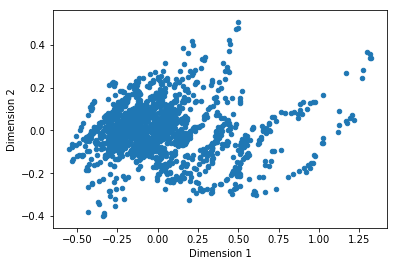

In [5]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2).fit(data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
reduced_data.plot.scatter(x='Dimension 1', y='Dimension 2')

To be updated

In [6]:
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics import silhouette_score

# TODO: Apply your clustering algorithm of choice to the reduced data 
#clusterer = mixture.GMM(n_components=3, n_init=10, n_iter=10).fit(reduced_data)
#keep the scores for each cluster size
sil_scores = []
for i in [5,4,3,2]:
    clusterer = KMeans(i, random_state=30).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
    #sample_preds = clusterer.predict(pca_samples)

    # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds)
    sil_scores.append(score)
    print i, 'clusters:', score.round(5)

5 clusters: 0.37511
4 clusters: 0.40995
3 clusters: 0.40787
2 clusters: 0.5906


To be updated

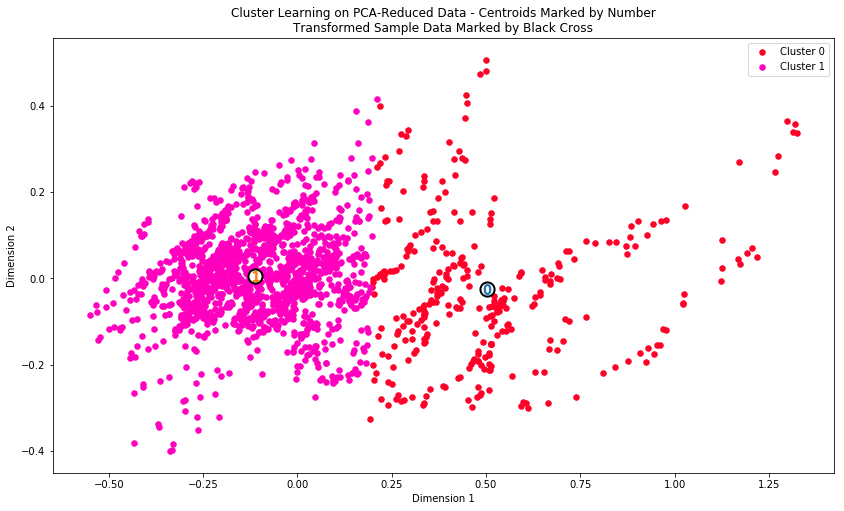

In [7]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers)

To be updated

In [8]:
# TODO: Inverse transform the centers
true_centers = pca.inverse_transform(centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(true_centers, columns = data.keys())
true_centers.index = segments
display(true_centers)

,SPY:Return(W),SPY:Return(M),SPY:Return(Q),NAS:Return(W),NAS:Return(M),NAS:Return(Q),SPY:Volume(W),SPY:Volume(M),SPY:Volume(Q),NAS:Volume(W),NAS:Volume(M),NAS:Volume(Q)
Segment 0,-0.000102,-0.000161,0.000006,-0.000206,-0.000220,0.000085,1.212949,1.191114,1.172267,1.169441,1.159766,1.160703
Segment 1,0.000557,0.000558,0.000529,0.000708,0.000707,0.000659,0.894413,0.901735,0.914926,0.951309,0.955834,0.964111


To be updated

In [1]:
import quandl
import utility as util

#quandl.ApiConfig.api_key = "dmDantC6pfu5ZsSZ9Zny"

#mkt_df = util.read_mkt_data('mktindex_price_volume.csv')
#date_range = ["2010-01-01", "2016-12-31"]
#date_index = mkt_df.index.get_values()
 
#stock_df = util.get_stock_data('SP500_list.csv', date_index, date_range)
#util.save_data('SP500_stocks_price.csv', stock_df)

0.3M Company Download & Parse complete
1.Abbott Laboratories Download & Parse complete
2.AbbVie Download & Parse complete
3.Accenture plc Download & Parse complete
4.ACE Limited Download & Parse complete
5.Activision Blizzard Download & Parse complete
6.Adobe Systems Inc Download & Parse complete
7.ADT Corp Download & Parse complete
8.Advance Auto Parts Download & Parse complete
9.AES Corp Download & Parse complete
10.Aetna Inc Download & Parse complete
11.AFLAC Inc Download & Parse complete
12.Affiliated Managers Group Inc Download & Parse complete
13.Agilent Technologies Inc Download & Parse complete
14.AGL Resources Inc. Download & Parse complete
15.Air Products & Chemicals Inc Download & Parse complete
16.Airgas Inc Download & Parse complete
17.Akamai Technologies Inc Download & Parse complete
18.Alcoa Inc Download & Parse complete
19.Allergan plc Download & Parse complete
20.Alexion Pharmaceuticals Download & Parse complete
21.Allegion Download & Parse complete
22.Alliance Data Sy

To be updated

In [22]:
import utility as util
import numpy as np

spy = util.read_mkt_data('mktindex_price_volume.csv')
spy = spy['SPY:Price']
spy.name = 'SP500'
# Preprocess data
#normalize = util.normalize_data(mkt_df)
stock_df = util.read_stock_data('SP500_stocks_price_Fake.csv')
stock_df = stock_df.join(spy)
#stock_df = util.fill_missing_values(stock_df)

List of companies dropped due to insufficient data
AbbVie
ACE Limited
ADT Corp
AGL Resources Inc.
Airgas Inc
Alcoa Inc
Allegion
Alphabet Inc Class C
Altera Corp
Baxalta
Broadcom Corporation
Cablevision Systems Corp.
Cameron International Corp.
Coca-Cola Enterprises
Columbia Pipeline Group Inc
Comcast Special Corp Class A
Computer Sciences Corp.
CONSOL Energy Inc.
Delphi Automotive
EMC Corp.
Ensco plc
Facebook
Fossil
General Motors
Genworth Financial Inc.
HCA Holdings
Hudson City Bancorp
Keurig Green Mountain
Kinder Morgan
Kraft Heinz Co
Legg Mason
LyondellBasell
Mallinckrodt Plc
Marathon Petroleum
McGraw Hill Financial
Westrock Co
Michael Kors Holdings
Navient
News Corp. Class A
News Corp. Class B
Nielsen Holdings
Owens-Illinois Inc
PayPal
Pepco Holdings Inc.
Phillips 66
Plum Creek Timber Co.
Precision Castparts
Qorvo
SanDisk Corporation
Sigma-Aldrich
Starwood Hotels & Resorts
TECO Energy
Tegna
Tenet Healthcare Corp.
Time Warner Cable Inc.
TripAdvisor
Tyco International
Walgreens Boots

To be updated

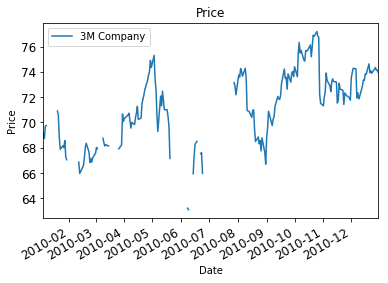

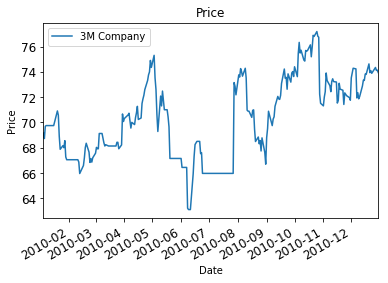

In [23]:
import matplotlib.pyplot as plt

date_range = ["2010-01-01", "2010-12-30"]

stocks = stock_df[['3M Company']]
util.plot_selected(stocks, ['3M Company'], 
                   date_range[0], date_range[1], 'Price')
util.fill_missing_values(stocks)
util.plot_selected(stocks, ['3M Company'], 
                   date_range[0], date_range[1], 'Price')
#stocks['Amazon.com Inc'].hist(bins = 30, label='Amazon.com Inc')
#stocks['SP500'].hist(bins = 30, label='SP500')
#plt.legend(loc='upper right')
#plt.show()

#daily_returns = util.compute_daily_returns(stock_df)
#util.plot_selected(daily_returns, ['Amazon.com Inc', 'SP500'], 
#                   date_range[0], date_range[1], 'Daily Return')
#daily_returns['Amazon.com Inc'].hist(bins = 50, label='Amazon.com Inc')
#daily_returns['SP500'].hist(bins = 50, label='SP500')
#plt.legend(loc='upper right')
#plt.show()

#util.print_statistics(daily_returns['Amazon.com Inc'])

#Scatterplot
#daily_returns.plot(kind='scatter', x='SP500', y='3M Company')
#beta, alpha = np.polyfit(daily_returns['SP500'], daily_returns['3M Company'], 1)
#Plot the fit line
#plt.plot(daily_returns['SP500'], beta*daily_returns['SP500']+alpha, '-', color = 'r')
#plt.show()

#Calculate correlation coefficient
#print daily_returns.corr(method='pearson')

To be updated

[ 0.365  0.     0.002  0.284  0.349]
[ 0.19   0.192  0.994]


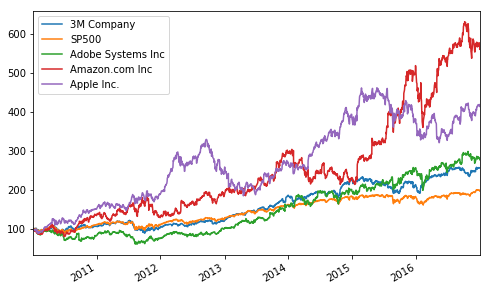

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sco
%matplotlib inline

def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(rets.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov()*252, weights)))
    return np.array([pret, pvol, pret/pvol])

def min_func_sharpe(weights):
    return -statistics(weights)[2]

date_range = ["2016-01-01", "2016-12-31"]
symbols = ['3M Company', 'SP500', 'Adobe Systems Inc', 'Amazon.com Inc', 'Apple Inc.']      
noa = len(symbols)
data = stock_df[symbols]
(data/data.ix[0]*100).plot(figsize=(8,5))

rets = np.log(data/data.shift(1))
#rets.mean() * 252
#rets.cov() * 252

cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

opts = sco.minimize(min_func_sharpe, noa * [1./noa,], method='SLSQP', bounds=bnds, constraints=cons)
print opts['x'].round(3)
print statistics(opts['x']).round(3)